### Analysis of Indel Recombitron data 


In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
from evaluation_functions import *

In [2]:
### first, we need to run CRISPResso2 on the data to get the indel frequencies ###
# we use the linker positions (retrons are constructed to create indels only at these sites) to represent "Cas9 cut sites" --> even though we dont use the Cas9 system, our system induces similar patterns in the sequences, thus we can perform the same analysis whereby the linker sequence represent the guide RNA
# the command (in the command line) is for instance:

#### for the forward read only (only first 150 positions of the LOV gene (+beginning of amplicon)) 

# CRISPResso --fastq_r1 RL1_R1_001.fastq --amplicon_seq CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTT -n RL1-R1_crispresso_result_final --guide_seq GAAGCGATTAACGAAAGCAGCGGT --cleavage_offset 0 --amplicon_min_alignment_score 50 --min_average_read_quality 20 --min_bp_quality_or_N 10  --offset_around_cut_to_plot 25 --window_around_sgrna 10  --min_frequency_alleles_around_cut_to_plot 0.00005 --needleman_wunsch_gap_incentive -20 --needleman_wunsch_gap_extend 0


#### for both (R1 and R2), however due to low coverage, many reads are not aligned well enough and thus excluded from the analysis

# CRISPResso --fastq_r1 RL1_R1_001.fastq --fastq_r2 RL1_R2_001.fastq --amplicon_seq CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG -n RL1_crispresso_result --guide_seq GAAGCGATTAACGAAAGCAGCGGT,TGAAAACATTGATGAAGCGGCCAAA --cleavage_offset 0



# CRISPResso --fastq_r1 revcomp_test.fastq  --amplicon_seq GAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG -n test --guide_seq GAAAACATTGATGAAGCGGCCAAA --cleavage_offset 0


# CRISPResso --fastq_r1 RL1_R2_001.fastq --amplicon_seq CACGCGGTTATCCATCGGCGGATGCAGGCTCCCTTTGGCCGCTTCATCAATGTTTTCAGCAGTCTTTTTAATTAACATTACACCTTCACGCTCCGCAGCATCGCGAACATGCTCGGTACCATCAAGCTGAACGCCAATGAAATACTGGACATCGCCCTTCTGGTCACGCATA -n RL1-R2_crispresso_result --guide_seq CACGCGGTTATCCATCGGCGGATGCAGGCTCCC --cleavage_offset 0



### reverse complement the sequences in the fastq files  to get the correct orientation of the sequences (in  command line)
 
# seqkit seq -r -p test.fastq -o revcomp_test.fastq -t DNA



In [2]:
### define the necessary variables

base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end = "ACATTGATGAAGCGGCCAAA"

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [6]:
insertions = [#"X",
   #"GG",
   # "PP",
    #"GXG"
    "GGSG",
    "GSGG",
    "GPPG",
    "GSGSG",
    "GPPPG",
    "GSGGSG",
    "GPPPPG"] +["G"+x+"G" for x in ecoli_pref.keys()] # + "GXG" AAs ## !!! "X" insertions are not included here, also "PP" and "GG" are not included here


In [7]:
insertion_codons = {insertion : "".join([ecoli_pref[Aa] for Aa in insertion]) for insertion in insertions }
subst = {Aa: "".join([ecoli_pref[a] for a in Aa]) for Aa in ["GG", "PP"]}
deletions = {"del1": "-"*9, # deletion of SG + deletion of the AA in front = total of 9 nucleotides
             "del2": "-"*12,
             "del3": "-"*15,}

In [8]:
## import data set from CRISPResso2 analysis

Allele_frequency = pd.read_csv("output/RL1-R1/CRISPResso_on_RL1-R1_crispresso_result_final/Alleles_frequency_table_around_sgRNA_GAAGCGATTAACGAAAGCAGCGGT.txt", sep = "\t")
# filter for alleles with a frequency > 0.01
Allele_frequency = Allele_frequency[Allele_frequency["%Reads"] > 0.05]


## in a few cases, four deletions but one insertion is defined, for which we think the read is wrongly aligned and which is only a deletion of 3 nucleotides with a mutation
## thus we combine # insertion - # deletion to define the size difference to the reference seq
Allele_frequency["size_diff"] =  Allele_frequency["n_inserted"] - Allele_frequency["n_deleted"]

wt_linker = "SG"

In [9]:
## test whether all size differences are triplets (quality check of the alignment)
sum(Allele_frequency["size_diff"] != Allele_frequency["size_diff"]//3*3) # all size differences are triplets

0

In [41]:
indel_codons_count = {}
intended_sequence_changes = []
# we now move all deletions to the end of the read 
## first we cut all the reads at the beginning of the LOV gene, thereby only keeping the linker sequence
LOV2_start = Allele_frequency.iloc[0,0].find("TTAGCCAC")
Allele_frequency["linker_seq"] = Allele_frequency.iloc[:,0].apply(lambda x: x[:LOV2_start])
## now we move all deletions to the end of the read
Allele_frequency["linker_sequence"] =  Allele_frequency.loc[:,"linker_seq"].apply(lambda x: x.replace("-","")) + ["-"*-x for x in Allele_frequency["size_diff"]]

linker_sequences_freq = Allele_frequency[["linker_sequence", "%Reads", "size_diff"]] 

## we can not count "X" indels directly, since these codons are present anyways in the reference sequence, thus we first need to select for deletion size = 3 
linker_reads_indelX = linker_sequences_freq[linker_sequences_freq["size_diff"] ==-3].copy()
linker_reads_indelX["indelX"] = [seq[-6:-3] for seq in linker_reads_indelX["linker_sequence"]]
for idx, indel_codon in enumerate(linker_reads_indelX["indelX"]):
    if indel_codon in ecoli_pref.values():
        indel_codons_count[translate_dna2aa(indel_codon)] =  {"prop": linker_reads_indelX.iloc[idx,1], "Codon": indel_codon}
        intended_sequence_changes.append(linker_reads_indelX.iloc[idx,0])
        
##search for substitutions only (GG or PP instead of SG)
linker_reads_subst = linker_sequences_freq[linker_sequences_freq["size_diff"] == 0].copy()
for AA_seq, codon in subst.items():
    for idx,sequence in enumerate(linker_reads_subst["linker_sequence"]):
        seq = sequence[-6:]
        if codon in seq:
            indel_codons_count[AA_seq] = {"prop": linker_reads_subst.iloc[idx,1], "Codon": codon}
            intended_sequence_changes.append(sequence)
    if AA_seq not in indel_codons_count.keys():
        indel_codons_count[AA_seq] = {"prop": 0, "Codon": codon}

## search for insertions
linker_reads_indels = linker_sequences_freq[linker_sequences_freq["size_diff"] >=1].copy()

for insertion_AA, insertion_codon in insertion_codons.items():
    expected_size_diff = (len(insertion_AA)-len(wt_linker))*3 # *3 because AA to nt level
    linker_reads_indels = linker_sequences_freq[linker_sequences_freq["size_diff"] == expected_size_diff].copy() ## filter for the correct size difference (e.g. GGSG insertion is also found in the GSGGSG insertion, thus we can not just search for the sequence but we need to filter for the correct size difference to filter for the correct insertion)
    for idx,seq in enumerate(linker_reads_indels["linker_sequence"]):
        if insertion_codon in seq:
                indel_codons_count[insertion_AA] = {"prop": linker_reads_indels.iloc[idx,1], "Codon": insertion_codon}
                intended_sequence_changes.append(seq)
    if insertion_AA not in indel_codons_count.keys():
        indel_codons_count[insertion_AA] = {"prop": 0, "Codon": insertion_codon}


# search for deletions
linker_reads_deletions = linker_sequences_freq[linker_sequences_freq["size_diff"] <-6].copy() ## deletions always include the linker thus a minimum of 6 nucleotides are deleted

for del_name, deletion in deletions.items():
    for idx,seq in enumerate(linker_reads_deletions["linker_sequence"]):
        if deletion.count("-") == seq.count("-"):
            indel_codons_count[del_name] = {"prop":linker_reads_deletions.iloc[idx,1], "Codon": deletion}
            intended_sequence_changes.append(seq)
        if del_name not in indel_codons_count.keys():
            indel_codons_count[del_name] = {"prop": 0, "Codon": deletion}

In [42]:
print(f"changes that can be explained by editing once by the RL were found in {len(intended_sequence_changes)} sequences ")
unintended_changes = [seq for seq in linker_sequences_freq["linker_sequence"] if seq not in intended_sequence_changes]
print(f"changes that can be explained by editing once by the RL were found in {len(unintended_changes)-1} sequences") #-1 because - reference sequence
## the unintended changes are: 
print(linker_sequences_freq[linker_sequences_freq["linker_sequence"].isin(unintended_changes)]) ## exclude the first row = reference sequence

changes that can be explained by editing once by the RL were found in 52 sequences 
changes that can be explained by editing once by the RL were found in 3 sequences
              linker_sequence     %Reads  size_diff
0   GGAAGCGATTAACGAAAGCAGCGGT  83.863415          0
1   GGAAGCGATTAACGAAAGCAGCGGC   0.738211          0
49  GGAAGCGATTAACGAAAGCAGCGGA   0.071545          0
53  GGAAGCGATTAACGAAAGCAGCGGT   0.065041          0


In [43]:
prop_of_changes = sum(Allele_frequency.loc[:,"%Reads"][1:])
intended_prop_of_changes = sum([x["prop"] for x in indel_codons_count.values()])
print(f"proportion of total changes: {prop_of_changes}")
print(f"proportion of intended changes: {intended_prop_of_changes}")
unintend_prop = prop_of_changes - intended_prop_of_changes

proportion of total changes: 12.04552845528455
proportion of intended changes: 11.170731707317069


In [44]:
unintend_prop

np.float64(0.8747967479674816)

In [45]:
sorted_indel_names = sorted(list(indel_codons_count.keys()))
sorted_indel_names = sorted(sorted_indel_names, key = len)

## resort del1, del2, del3 to the end
sorted_indel_names = [x for x in sorted_indel_names if x not in deletions.keys()] + sorted([x for x in sorted_indel_names if x in deletions.keys()], key = len)

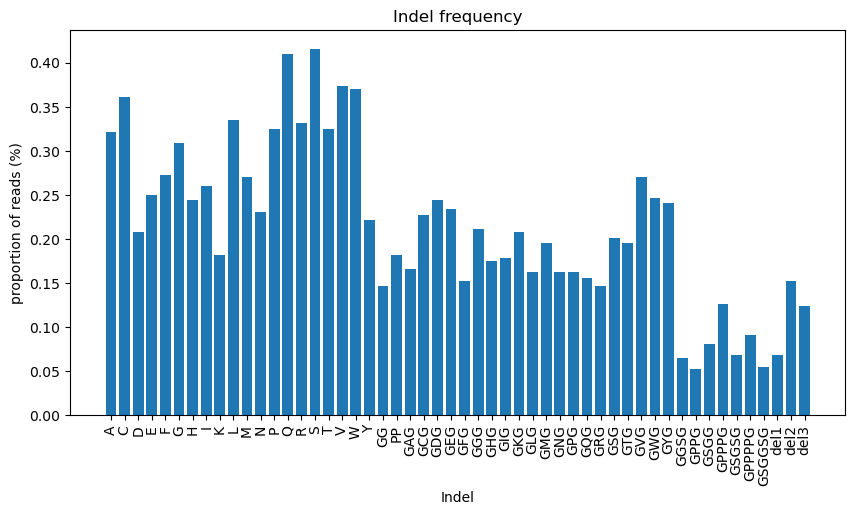

In [48]:
insertion_props = {k: indel_codons_count[k]["prop"] for k in sorted_indel_names}
plt.figure(figsize=(10,5))
plt.bar(list(insertion_props.keys()), list(insertion_props.values()))
plt.xticks(rotation=90)
plt.ylabel("proportion of reads (%)")
plt.title("Indel frequency")
plt.xlabel("Indel")
plt.savefig("output/RL1-R1/Indel_frequency.pdf", bbox_inches = "tight")
plt.show()

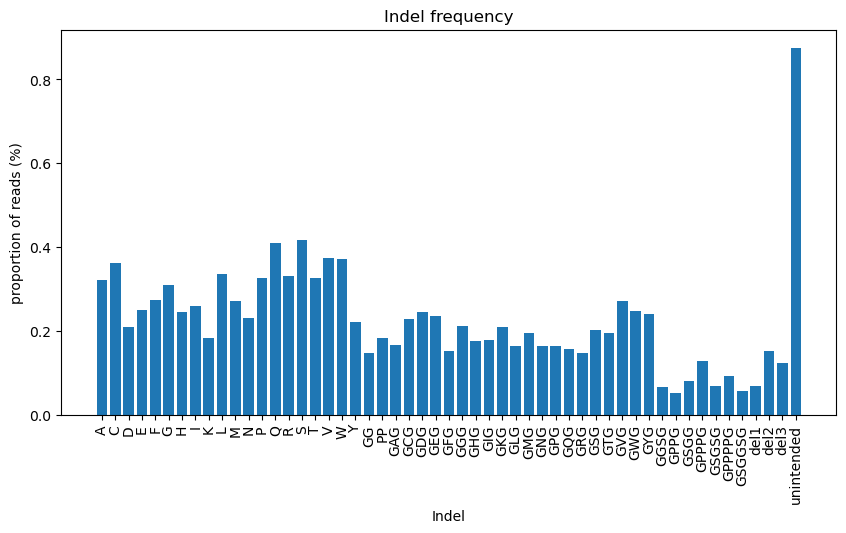

In [49]:
insertion_props = {k: indel_codons_count[k]["prop"] for k in sorted_indel_names}
plt.figure(figsize=(10,5))
plt.bar(list(insertion_props.keys())+["unintended"], list(insertion_props.values())+[unintend_prop])
plt.xticks(rotation=90)
plt.ylabel("proportion of reads (%)")
plt.title("Indel frequency")
plt.xlabel("Indel")
plt.savefig("output/RL1-R1/Indel_frequency_withUnintended.pdf", bbox_inches = "tight")
plt.show()

#### Sequence based analysis (not relying on CRISPResso)

In [3]:
### read sequences from fastq files

seqs = read_sequences("RL1", catch_left="", catch_right="")

total reads 48196


In [4]:
"AAAGC"

print(len(seqs[0])) # number of sequences
print(sum(["TTAACGAAAGC" in seq for seq in seqs[0]]))

48196
41327


In [45]:
[dna_rev_comp(seq)[dna_rev_comp(seq).index("GCGGCCAAA"):] if "GCGGCCAAA" in dna_rev_comp(seq) else "" for seq in seqs[1]]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 'GCGGCCAAATATCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 'GCGGCCAAAACCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 'GCGGCCAAAGGCGGCAGCGGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 '',
 '',
 '',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 'GCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGGGG',
 ''

In [42]:
sum(["GCGGCCAAA" in dna_rev_comp(seq) for seq in seqs[1]])
[dna_rev_comp(seq)[dna_rev_comp(seq).index("GCGGCCAAA")-6:dna_rev_comp(seq).index("GCGGCCAAA")+6+len("GCGGCCAAA")+8] if "GCGGCCAAA" in dna_rev_comp(seq) else "" for seq in seqs[1]]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAGGCGGCCAAATATCTGCATCCGCC',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 'GATGAGGCGGCCAAAACCCTGCATCCGCC',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAGGCGGCCAAAGGCGGCAGCGGCCT',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 'GATGAGGCGGCCAAAATGCTGCATCCGCC',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 '',
 '',
 '',
 '',
 '',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAAGCGGCCAAAGGGAGCCTGCATCC',
 'GATGAGGCGGCCAAATTTCTGCATCCGCC',
 '',
 '',
 'GATGAGGCGGCCAAA

In [47]:
reads = [dna_rev_comp(seq) for seq in seqs[1]]

In [131]:
seq_before_linker = "GCGGCCAAA"#"TTAACGAAAGC"
seq_after_linker ="CTGCATCC"#"TTAGCCACAA"
total_seq = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTGC"#"GCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCT" # sequence from start until linker
adaptor_left = "CCCC"
linker_seq = "GGGAGC" 
reads = [dna_rev_comp(seq) for seq in seqs[1]]


# seq_before_linker = "TTAACGAAAGC"
# seq_after_linker ="TTAGCCACAA"
# total_seq = "GCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCT" # sequence from start until linker
# adaptor_left = "CCCC"
# linker_seq = "AGCGGT"
# reads = seqs[0]

print("total reads",len(reads)) # number of sequences
print("reads with target sequence", sum(["CTGCATCC" in seq for seq in seqs[0]])) ## sum of seqences that include the sequence after the linker

def get_linker_variants(reads, seq_before_linker, seq_after_linker, linker_seq, total_seq_before_linker, adaptor, include_other = False, include_deletions = True):
    """
    get linker variants

    reads: list of sequences (if R2 read, call dna_rev_comp on the sequences prior to calling this function)
    seq_before_linker: short DNA sequence before the linker (8-10 bp)
    seq_after_linker: short DNA sequence after the linker
    linker_seq: linker DNA sequence
    total_seq_before_linker: sequence from the beginning of the read until the linker sequence
    adaptor: adaptor sequence
    include_other: whether or not to include reads that do not contain the sequence after linker, but are in principle long enough, in the analysis (default: False) -> are counted as "other" --> probably due to unintended changes, mutations or sequencing errors (intended changes are all located prior to or in the linker sequence, i.e. the sequence after the linker should not be affected by the retron editing)
    include_deletions: whether or not to include deletions in the analysis (default: True) 
    returns: dictionaries with (1) counts, (2) percents of linker variants
        """
    linker_variants = {}
    for seq in reads:   ## indels and mutations
        if seq_before_linker in seq and seq_after_linker in seq: ## only consider reads that contain the linker position
            start_idx = seq.index(seq_before_linker) + len(seq_before_linker)
            stop_idx = seq.index(seq_after_linker)
            linker = seq[start_idx:stop_idx]
            if linker in linker_variants.keys():
                linker_variants[linker] += 1
            else: 
                linker_variants[linker] = 1

        elif include_deletions: ## deletions
            if seq_after_linker in seq and seq_before_linker not in seq: ## because for deletions, we delete at least three bases from the seq before the linker, i.e. seq_before linker is not anymore completely in seq
                seq_with_deletion = seq[len(adaptor_left):seq.index(seq_after_linker)]
                if seq_with_deletion in total_seq:
                    del_len = total_seq.index(seq_with_deletion)+len(seq_with_deletion) - total_seq.index(seq_after_linker)
                    if del_len <=0: ## insertion but mutations in seq_before_linker, thus seq_before_linker is not in seq but we do not want to consider these reads
                        delname = "del"+str(del_len)
                        if delname in linker_variants.keys():
                            linker_variants[delname] += 1
                        else:
                            linker_variants[delname] = 1

        elif include_other: ## other (untargeted changes that effect the sequence after the linker)
            if len(seq) >= len(total_seq)+len(linker_seq)+len(seq_after_linker):
                print(seq)
                if "other" not in linker_variants.keys():
                    linker_variants["other"] = 1
                else:
                    linker_variants["other"] += 1

    total_vars = sum(linker_variants.values())
    ### percentage
    linker_variants_perc = {seq: count/total_vars*100 for seq,count in linker_variants.items()}
    ## exclude everything below 0.1%
    linker_variants_perc = {seq: count for seq,count in linker_variants_perc.items() if count > 0.05}
    ## order after value size
    linker_variants_perc = dict(sorted(linker_variants_perc.items(), key = lambda x: x[1], reverse = True))
    ### convert dict keys to AAs
    linker_variants_perc_AA = {(translate_dna2aa(seq) if seq[0] in ["A","C","G","T"] else seq) : count for seq,count in linker_variants_perc.items()}
    linker_variants_perc_AA = dict(sorted(linker_variants_perc_AA.items(), key = lambda x: x[1], reverse = True))

    return linker_variants, linker_variants_perc, linker_variants_perc_AA






total reads 48196
reads with target sequence 12031
TCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
AGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
CGGCGACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
GACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCACATGGAAGCGATGGATAACCGCGTGCGGGG
CGACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATTGATAACCGCGTGCGGGG
CGGCGACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
CTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
ACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
CCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
ACCACCGAGATCTACACAGTACAAGACACTCTTTCCCTACACGACGCTCTTCCGATCTCCCCGCCGCATGGAAGCGATGGATAACCGCGTGCGGGG
TACGG

In [132]:
total_vars = sum(linker_variants.values())
### percentage
linker_variants_perc = {seq: count/total_vars*100 for seq,count in linker_variants.items()}
## exclude everything below 0.1%
linker_variants_perc = {seq: count for seq,count in linker_variants_perc.items() if count > 0.05}
## exclude reference sequence
linker_variants_perc = {seq: count for seq,count in linker_variants_perc.items() if seq != linker_seq}#"AGCGGT"}#GGGAGC
## order after value size
linker_variants_perc = dict(sorted(linker_variants_perc.items(), key = lambda x: x[1], reverse = True))
### convert dict keys to AAs
linker_variants_perc_AA = {(translate_dna2aa(seq) if seq[0] in ["A","C","G","T"] else seq) : count for seq,count in linker_variants_perc.items()}
linker_variants_perc_AA = dict(sorted(linker_variants_perc_AA.items(), key = lambda x: x[1], reverse = True))

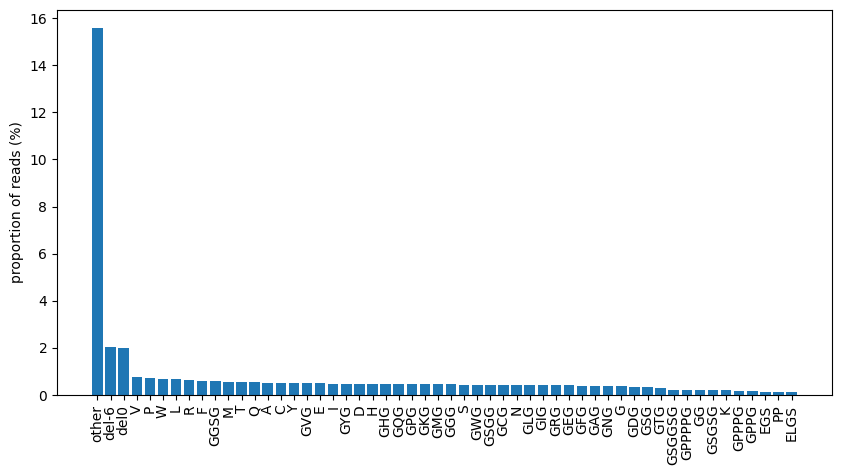

In [133]:
plt.figure(figsize=(10,5))
plt.bar(list(linker_variants_perc_AA.keys()), list(linker_variants_perc_AA.values()))
plt.xticks(rotation=90)
plt.ylabel("proportion of reads (%)")  
plt.savefig("output/RL1/linker_R1_indel_AA_freq.pdf", bbox_inches = "tight")    
plt.show()

In [102]:
translate_dna2aa("AAA")

'K'

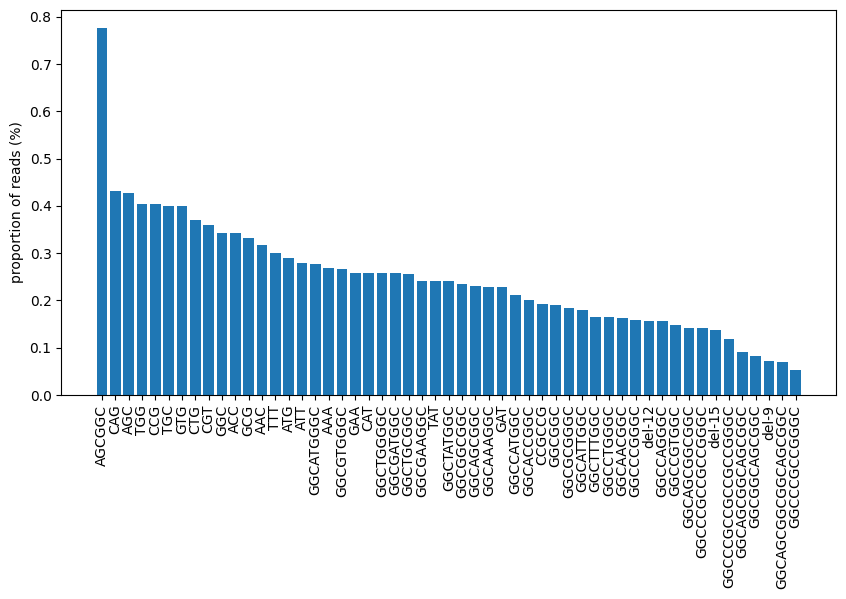

In [116]:
plt.figure(figsize=(10,5))
plt.bar(list(linker_variants_perc.keys()), list(linker_variants_perc.values()))
plt.xticks(rotation=90)
plt.ylabel("proportion of reads (%)")  
plt.savefig("output/RL1/linker_R1_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()
